### Velocity estimation using homography

Original code by Mouna El Borgi\
Modified by Azilis Even to be applied to collisions between 2 people (ex: 2 ice hockey players) using openpose keypoints 

Version used to compare the tracking methods and filtering windows

In [1]:
import cv2, os, math, csv
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
import os
import json

First run the two cells below to extract the frames from the video

In [2]:
### FILL IN ####

# Enter video directory
# /!\ The video needs to have been stabilised previously to keep the homography valid between frames
# if not, the homography and landmark selection step needs to be included in the loop
video_dir = 'D:/Utilisateurs/Azilis/Documents/_Thesis/videos-processed/2018-03-14_brynas-lulea_impact_stabilised.mp4'

# Results directory
dir_case = "other-seasons/2018-03-14_brynas-lulea-tracking-tests"

# Ground plane image - cropped as close as possible to the rink size
img_dst_dir = "D:/Utilisateurs/Azilis/Documents/_Thesis/master-thesis-kth/5-homography/iihf_rink.png"

#Choose tracking method in ["pelvis", "midfeet"] ###
#method = "midfeet"

# Indicate frame with the impact
impact_frame = 11

# Check visually if at some point the players cross horizontally 
# (ie the pelvis of the one originally on the left is now on the right)
# (you can run the pelvis method once and see if the tracker color changes and for which image)
# If yes, change switch to "True" and indicate the image number where the switch occurs for the first time
switch = False
#frame_switch = 18

In [3]:
# Create results directory
if not os.path.exists(dir_case):
    os.mkdir(dir_case)

# Create image folder directory for the frames from the video
dir_img = dir_case + "/images"
if not os.path.exists(dir_img):
    os.mkdir(dir_img)
    
# Create keypoints directory
dir_annot = dir_case + "/keypoints"
if not os.path.exists(dir_annot):
    os.mkdir(dir_annot)
    
# Tracking methods
dir_pelvis_proj = dir_case + "/images-pelvis-proj"
if not os.path.exists(dir_pelvis_proj):
    os.mkdir(dir_pelvis_proj)
dir_midfeet_proj = dir_case + "/images-midfeet-proj"
if not os.path.exists(dir_midfeet_proj):
    os.mkdir(dir_midfeet_proj)
dir_pelvis_low = dir_case + "/images-pelvis-low"
if not os.path.exists(dir_pelvis_low):
    os.mkdir(dir_pelvis_low)
dir_midfeet_low = dir_case + "/images-midfeet-low"
if not os.path.exists(dir_midfeet_low):
    os.mkdir(dir_midfeet_low)
methods_dir = {"pelvis": dir_pelvis_proj, "midfeet": dir_midfeet_proj, "pelvis-low": dir_pelvis_low, "midfeet-low": dir_midfeet_low}

dir_comparison = dir_case + "/images-comparison"
if not os.path.exists(dir_comparison):
    os.mkdir(dir_comparison)
colors_dir = {"pelvis": (255, 0, 0), "midfeet": (0, 165, 255), "pelvis-low": (0, 255, 0), "midfeet-low": (0, 0, 255)}

In [4]:
video = cv2.VideoCapture(video_dir)
# Get number of frames
nrOfframes = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
print("Number of frames: " + str(nrOfframes))
# Get FPS
fps = int(video.get(cv2.CAP_PROP_FPS)) # Hz
sequencelength = nrOfframes/fps
print("Duration of the impact video: " + str(sequencelength) + " s")

i = 0
while True:
    ret, image = video.read()
    if ret == False:
        break
    cv2.imwrite(dir_img + '/image' + '0'*(len(str(nrOfframes))-len(str(i))) + str(i) + '.jpg', image)
    cv2.imwrite(dir_comparison + '/image' + '0'*(len(str(nrOfframes))-len(str(i))) + str(i) + '.jpg', image)
    i+= 1

video.release()

Number of frames: 15
Duration of the impact video: 0.6 s


Then go run OpenPose on these images, and use a tool like PoseAnnotator to clean the keypoints files (remove non-needed people, correct errors etc) \
Save the final keypoints in `dir_annot` then run the rest of the code

In [5]:
### FILL IN ###

# If didn't run the video to frames cell in this kernel
#nrOfframes = len([name for name in os.listdir(dir_img) if os.path.isfile(os.path.join(dir_img, name))])
#print(nrOfframes)
#fps = 25
#sequencelength = nrOfframes/fps

# Ground plane image - cropped exactly at the rink size
# Enter pixel length for x and y in meters (dimensions of the IIHF rink)
x_in_meters = 30
y_in_meters = 60

###############

# Get dimensions in pixel of the ground plane image
img_ground=cv2.imread(img_dst_dir)
x_in_pixels=img_ground.shape[1]
y_in_pixels=img_ground.shape[0]
print("Dimensions in pixels of the rink: width " +str(x_in_pixels)+ ", height " +str(y_in_pixels))

# Source image - used as reference to find the homography matrix
image_path_src = dir_img + "/image" +'0'*(len(str(nrOfframes))-1) + "1.jpg"
image_src=cv2.imread(image_path_src)
x_in_pixels_img=image_src.shape[1]
y_in_pixels_img=image_src.shape[0]
print("Dimensions in pixels of the images: width " +str(x_in_pixels_img)+ ", height " +str(y_in_pixels_img))

Dimensions in pixels of the rink: width 1344, height 667
Dimensions in pixels of the images: width 1280, height 720


In [6]:
# Keypoints id (order in the results)
# Each joint has x, y, confidence_interval info in the json file

MidHip = 8
RAnkle = 11
LAnkle = 14
LBigToe = 19
LSmallToe = 20
LHeel = 21
RBigToe = 22
RSmallToe = 23
RHeel = 24

In [7]:
# https://web.archive.org/web/20111108065352/https://www.cs.mun.ca/~rod/2500/notes/numpy-arrays/numpy-arrays.html
#
# line segment intersection using vectors
# see Computer Graphics by F.S. Hill
#
def perp( a ) :
    b = np.empty_like(a)
    b[0] = -a[1]
    b[1] = a[0]
    return b

# line segment a given by endpoints a1, a2
# line segment b given by endpoints b1, b2
# return 
def seg_intersect(a1,a2, b1,b2) :
    da = a2-a1
    db = b2-b1
    dp = a1-b1
    dap = perp(da)
    denom = np.dot( dap, db)
    num = np.dot( dap, dp )
    return (num / denom.astype(float))*db + b1

In [8]:
# Extract tracking point from player keypoints

def tracking(keypoints, methods):
    if method == "pelvis":
        # Version with pelvis projection on the ground
        # Vertical segment going through the pelvis
        x = keypoints['pose_keypoints_2d'][MidHip*3]
        LFoot_y = max(keypoints['pose_keypoints_2d'][LBigToe*3+1], keypoints['pose_keypoints_2d'][LSmallToe*3+1], keypoints['pose_keypoints_2d'][LHeel*3+1])
        RFoot_y = max(keypoints['pose_keypoints_2d'][RBigToe*3+1], keypoints['pose_keypoints_2d'][RSmallToe*3+1], keypoints['pose_keypoints_2d'][RHeel*3+1])
        y = (LFoot_y + RFoot_y)/2
        return (x, y)
    
    elif method == "midfeet":
        # Version with projection of the middle of the two feet
        # x-value: middle of the 2 ankles 
        x = (keypoints['pose_keypoints_2d'][LAnkle*3] + keypoints['pose_keypoints_2d'][RAnkle*3])/2
        # y-value: approx the ground level with the lowest body point (visually on the image) ie the highest y-value in the keypoints
        y = (keypoints['pose_keypoints_2d'][LAnkle*3+1] + keypoints['pose_keypoints_2d'][RAnkle*3+1])/2
        return (x, y)
    
    elif method == "pelvis-low":
        # Version with pelvis projection on the ground
        # x-value: direct projection from the pelvis on the ground
        x = keypoints['pose_keypoints_2d'][MidHip*3]
        # y-value: approx the ground level with the lowest body point (visually on the image) ie the highest y-value in the keypoints
        LFoot_y = max(keypoints['pose_keypoints_2d'][LBigToe*3+1], keypoints['pose_keypoints_2d'][LSmallToe*3+1], keypoints['pose_keypoints_2d'][LHeel*3+1])
        RFoot_y = max(keypoints['pose_keypoints_2d'][RBigToe*3+1], keypoints['pose_keypoints_2d'][RSmallToe*3+1], keypoints['pose_keypoints_2d'][RHeel*3+1])
        y = max(LFoot_y, RFoot_y)
        return (x, y)
    
    elif method == "midfeet-low":
        # Version with projection of the middle of the two feet
        # x-value: middle of the 2 ankles 
        x = (keypoints['pose_keypoints_2d'][LAnkle*3] + keypoints['pose_keypoints_2d'][RAnkle*3])/2
        # y-value: approx the ground level with the lowest body point (visually on the image) ie the highest y-value in the keypoints
        LFoot_y = max(keypoints['pose_keypoints_2d'][LBigToe*3+1], keypoints['pose_keypoints_2d'][LSmallToe*3+1], keypoints['pose_keypoints_2d'][LHeel*3+1])
        RFoot_y = max(keypoints['pose_keypoints_2d'][RBigToe*3+1], keypoints['pose_keypoints_2d'][RSmallToe*3+1], keypoints['pose_keypoints_2d'][RHeel*3+1])
        y = max(LFoot_y, RFoot_y)
        return (x, y)

In [9]:
posList = []
def onMouse(event, x, y, flags, params):
  
    global posList
    # checking for left mouse clicks
    if event == cv2.EVENT_LBUTTONDOWN:
        # displaying the coordinates
        posList.append((x,y))

In [10]:
# Tranformation of one point corrdinate to ground plane
def homographyTransform(coord, img, src_pts, dst_pts, showResult=False):

    H, status = cv2.findHomography(src_pts, dst_pts)
    img_out = cv2.warpPerspective(img, H, (img.shape[1], img.shape[0]))
    coordi = []
    #p = coord[0]
    p = coord
    px = (H[0][0]*p[0] + H[0][1]*p[1] + H[0][2]) / ((H[2][0]*p[0] + H[2][1]*p[1] + H[2][2]))
    py = (H[1][0]*p[0] + H[1][1]*p[1] + H[1][2]) / ((H[2][0]*p[0] + H[2][1]*p[1] + H[2][2]))
    rider = (float(px), float(py))
    coordi.append(rider)
    

    if showResult:
        cv2.imshow('homographyTransformation',img_out)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
    return coordi

In [11]:
# Tranformation for a whole list of coordinates to ground plane
def homographyTransform_list(coord, img, src_pts, dst_pts):

    H, status = cv2.cv2.findHomography(src_pts, dst_pts)
    img_out = cv2.warpPerspective(img, H, (img.shape[1], img.shape[0]))
    coordi = []
    for i in range(len(coord)):
        p = coord[i]
        px = (H[0][0]*p[0] + H[0][1]*p[1] + H[0][2]) / ((H[2][0]*p[0] + H[2][1]*p[1] + H[2][2]))
        py = (H[1][0]*p[0] + H[1][1]*p[1] + H[1][2]) / ((H[2][0]*p[0] + H[2][1]*p[1] + H[2][2]))
        rider = (float(px), float(py))
        coordi.append(rider)

    return coordi

In [12]:
# Choosing the four points of reference for ground plane image and their correspondence in the source image
# This is then used to compute the homography matrix

if os.path.isfile(dir_case + "/ref-points-src.npy"):
    src_pts = np.load(dir_case + "/ref-points-src.npy")
else:
    cv2.namedWindow('img', cv2.WINDOW_FULLSCREEN)
    img = cv2.imread(image_path_src)
    #img_resized = cv2.resize(img, (1280, 720))
    cv2.imshow('img',img)
    cv2.setMouseCallback('img', onMouse)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    src_pts = np.array(posList)
    posList.clear()
    with open(dir_case + "/ref-points-src.npy", "wb") as f:
        np.save(f, src_pts)
print("Position of reference points in source image: \n", src_pts)


if os.path.isfile(dir_case + "/ref-points-ground.npy"):
    dst_pts = np.load(dir_case + "/ref-points-ground.npy")
else:
    cv2.namedWindow('dest_img', cv2.WINDOW_FULLSCREEN)
    img_dst = cv2.imread(img_dst_dir)
    #imS = cv2.resize(img_dst, (1920, 1080))
    cv2.imshow('dest_img',img_dst)
    cv2.setMouseCallback('dest_img', onMouse)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    dst_pts = np.array(posList)
    posList.clear()
    with open(dir_case + "/ref-points-ground.npy", "wb") as f:
        np.save(f, dst_pts)
print("Position of reference points in ground view: \n", dst_pts)

Position of reference points in source image: 
 [[ 171  210]
 [ 197  208]
 [ 167  479]
 [1229  217]]
Position of reference points in ground view: 
 [[ 838    0]
 [ 849    0]
 [ 806  176]
 [1100   77]]


In [13]:
# Tracking both players
img_ground_annot = img_ground.copy()

# Adapt to tracking method in ["pelvis", "midfeet"] ###
for method in methods_dir.keys():
    dir_proj = methods_dir[method]

    pos_array_player1 = []
    pos_array_player2 = []

    i = 0
    for filename in os.listdir(dir_annot):
        keypoints_path = os.path.join(dir_annot, filename)
        # checking if it is a file
        if os.path.isfile(keypoints_path):
            #print("Tracking players in " + filename)
            # Open the file
            with open(keypoints_path) as f:
                keypoints = json.load(f)
                f.close()
            # Open the corresponding image    
            image_path = dir_img + "/" + filename.split("_")[0] + ".jpg"
            img = cv2.imread(image_path)   

            # Read keypoints and identify the players (1 or 2, with 1 the one most to the left of the image)
            if switch and i >= frame_switch:
                if keypoints['people'][0]['pose_keypoints_2d'][MidHip*3] > keypoints['people'][1]['pose_keypoints_2d'][MidHip*3]:
                    keypoints_player1 = keypoints['people'][0]
                    keypoints_player2 = keypoints['people'][1]
                else:
                    keypoints_player2 = keypoints['people'][0]
                    keypoints_player1 = keypoints['people'][1]
                #print('switched frame')
            else:
                if keypoints['people'][0]['pose_keypoints_2d'][MidHip*3] < keypoints['people'][1]['pose_keypoints_2d'][MidHip*3]:
                    keypoints_player1 = keypoints['people'][0]
                    keypoints_player2 = keypoints['people'][1]
                else:
                    keypoints_player2 = keypoints['people'][0]
                    keypoints_player1 = keypoints['people'][1]        

            # Calculate tracking points from the joint positions
            coord_player1 = tracking(keypoints_player1, method)
            #coord_player1 = (keypoints_player1['pose_keypoints_2d'][RBigToe*3], keypoints_player1['pose_keypoints_2d'][RBigToe*3+1])
            coord_player2 = tracking(keypoints_player2, method)
            #coord_player2 = (keypoints_player2['pose_keypoints_2d'][RBigToe*3], keypoints_player2['pose_keypoints_2d'][RBigToe*3+1])
            #print(coord_player1)

            # Homography
            coordi_player1 = homographyTransform(coord_player1, img, src_pts, dst_pts, False)
            coordi_player2 = homographyTransform(coord_player2, img, src_pts, dst_pts, False)

            # Append result to position of each players
            pos_array_player1.append(coordi_player1[0])
            pos_array_player2.append(coordi_player2[0])

            # Visualisation     
            img_annotated = cv2.circle(img, (round(coord_player1[0]),round(coord_player1[1])), radius=5, color=(255, 0, 0), thickness=-1)
            cv2.circle(img_annotated, (round(coord_player2[0]),round(coord_player2[1])), radius=5, color=(0, 0, 255), thickness=-1)
            font = cv2.FONT_HERSHEY_SIMPLEX
            cv2.putText(img_annotated,method+" tracking",(img_annotated.shape[1]-300,img_annotated.shape[0]-20), font, 1,(255,255,255),2,cv2.LINE_AA)
            cv2.imwrite(dir_proj + "/" + filename.split("_")[0] + "_" + method +"_tracking" + ".jpg", img_annotated)

            # Visualisation comparison
            image_path = dir_comparison + "/" + filename.split("_")[0] + ".jpg"
            img = cv2.imread(image_path) 
            img_annotated = cv2.circle(img, (round(coord_player1[0]),round(coord_player1[1])), radius=5, color=colors_dir[method], thickness=-1)
            cv2.circle(img_annotated, (round(coord_player2[0]),round(coord_player2[1])), radius=5, color=colors_dir[method], thickness=-1)
            cv2.imwrite(dir_comparison + "/" + filename.split("_")[0] + ".jpg", img_annotated)
            
            i+=1

    #print(pos_array_player1)
    #print(pos_array_player2)

    # Save arrays of positions just in case it is needed later
    with open(dir_case + "/player1-" + method +"_tracking" + ".json", "w") as f:
        json.dump(pos_array_player1, f, indent=2)
    with open(dir_case + "/player2-" + method +"_tracking" + ".json", "w") as f:
        json.dump(pos_array_player2, f, indent=2)
    print("Done with " + method)
    
    # Save positions on bird eye view
    for i in range(len(pos_array_player1)):
        cv2.circle(img_ground_annot, (round(pos_array_player1[i][0]),round(pos_array_player1[i][1])), radius=5, color=colors_dir[method], thickness=-1)
        cv2.circle(img_ground_annot, (round(pos_array_player2[i][0]),round(pos_array_player2[i][1])), radius=5, color=colors_dir[method], thickness=-1)
    cv2.imwrite(dir_case + "/tracking-ground.jpg", img_ground_annot)
    print("Done saving ground tracking")

Done with pelvis
Done saving ground tracking
Done with midfeet
Done saving ground tracking
Done with pelvis-low
Done saving ground tracking
Done with midfeet-low
Done saving ground tracking


In [14]:
def filtration(coor, window, poly):

    c0 = coor[::2]
    c1 = coor[1::2]
    c0_new = signal.savgol_filter(c0, window, poly)
    c1_new = signal.savgol_filter(c1, window, poly)

    new_coor = coor.copy()
    new_coor[::2] = c0_new
    new_coor[1::2] = c1_new

    return new_coor

In [15]:
def velocity(array_rider, dst_pts, nrOfframes, sequencelength, window, poly, name, filter =False, save = False):

    # Pixellength in meter
    pixellength_x = x_in_meters/x_in_pixels
    pixellength_y = y_in_meters/x_in_pixels

    t = sequencelength/float(nrOfframes)
    time = t
    velocity_2D = [0]*(nrOfframes-1)

    velocity_x = [0]*(nrOfframes-1)
    velocity_y = [0]*(nrOfframes-1)

    time_array = [0]*(nrOfframes-1)

    x = [val[0] for val in array_rider]; y = [val[1] for val in array_rider]

    if filter:
        x = filtration(x, window, poly)
        y = filtration(y, window, poly)

    for i in range(nrOfframes-1):

        # displacement in meters for x and y coordinates

        dx_rider = (x[i+1]-x[i])*pixellength_x
        dy_rider = (y[i+1]-y[i])*pixellength_y

        # velocity array in meter
        velocity_x[i] = dx_rider/t        
        velocity_y[i] = dy_rider/t

        velocity_2D[i] = math.sqrt(((velocity_x[i])**2)+((velocity_y[i])**2))

        time_array[i] = time
        time += t
    if filter:
        velocity_2D = signal.savgol_filter(velocity_2D, 4, 1)

    average_v = np.mean(velocity_2D)*3.6
    print('average velocity in km/h', average_v)
    
    header = ['time','x','y','velocity_x', 'velocity_y', 'velocity_2D']
    if save:
        save_csv = dir_case + '/' + name + "-" + method +"_tracking" + '.csv'
        with open(save_csv, 'w', encoding='UTF8', newline='') as f:
            writer = csv.writer(f)
            # write the header
            writer.writerow(header)
            for w in range(len(velocity_2D)):
                writer.writerow([time_array[w], x[w], y[w], velocity_x[w], velocity_y[w], velocity_2D[w]])
    
    return time_array, velocity_2D, average_v
    
def plot_velocity(velocity_2D, time_array, sequencelength, name):
    ax.plot(time_array, velocity_2D, marker='o',label = name)
    plt.xlim(0, sequencelength)
    plt.legend()
    ax.set(xlabel='Time (s)', ylabel='Velocity (m/s)', title='Player velocity vs time')

average velocity in km/h 23.71545285553435
average velocity in km/h 26.066909425963615
average velocity in km/h 26.469176249157005
average velocity in km/h 27.56679648881099


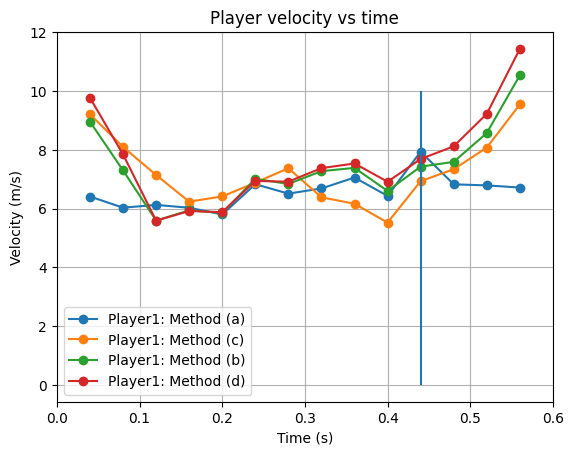

average velocity in km/h 21.813421605187678
average velocity in km/h 24.837000317334535
average velocity in km/h 22.69322905136601
average velocity in km/h 22.93740517102896


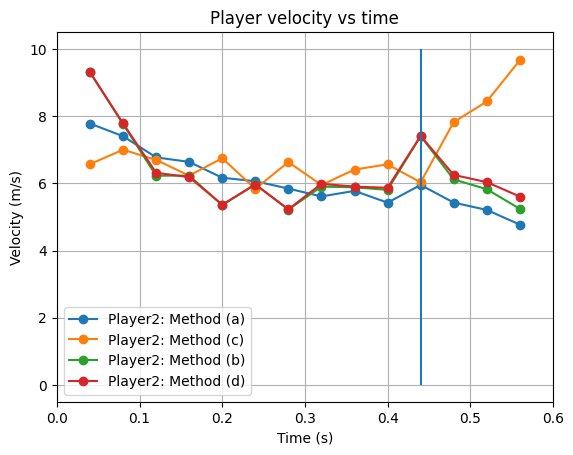

In [21]:
# Enter filtration window for savgol filter
window = 7
# Alter true to False if you don't wont to use the filter or save
method_title_dir = {"pelvis": "Method (a)", "midfeet": "Method (c)", "pelvis-low": "Method (b)", "midfeet-low": "Method (d)"}

# Player 1
fig, ax = plt.subplots()
for method in methods_dir.keys():
    with open(dir_case + "/player1-" + method +"_tracking" + ".json") as f:
        pos_array_player1 = json.load(f)
        f.close()
    time_array, velocity_2D, average_v = velocity(pos_array_player1, dst_pts, nrOfframes, sequencelength,window, 3, 'velocity_player1', True, True)
    plot_velocity(velocity_2D, time_array, sequencelength, 'Player1: '+method_title_dir[method])
ax.grid()
plt.vlines(impact_frame/fps, 0, 10)
save_plot = dir_case + '/velocity_player1.png'
plt.savefig(save_plot)
plt.show()

# Player 2
fig, ax = plt.subplots()
for method in methods_dir.keys():
    with open(dir_case + "/player2-" + method +"_tracking" + ".json") as f:
        pos_array_player2 = json.load(f)
        f.close()
    time_array, velocity_2D, average_v = velocity(pos_array_player2, dst_pts, nrOfframes, sequencelength,window, 3, 'velocity_player2', True, True)
    plot_velocity(velocity_2D, time_array, sequencelength, 'Player2: '+method_title_dir[method])
ax.grid()
plt.vlines(impact_frame/fps, 0, 10)
save_plot = dir_case + '/velocity_player2.png'
plt.savefig(save_plot)
plt.show()

average velocity in km/h 21.681668274388787
average velocity in km/h 23.71545285553435


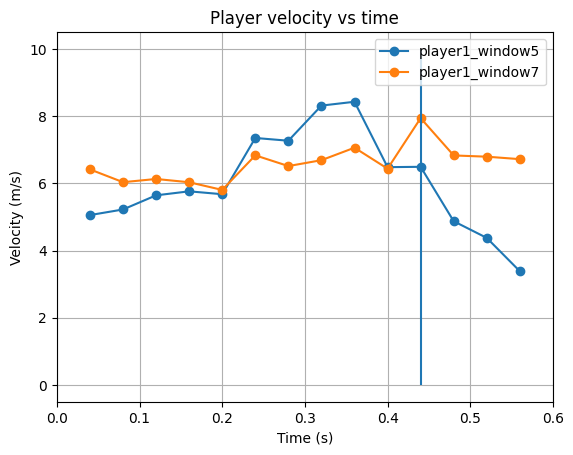

average velocity in km/h 21.97174834238972
average velocity in km/h 21.813421605187678


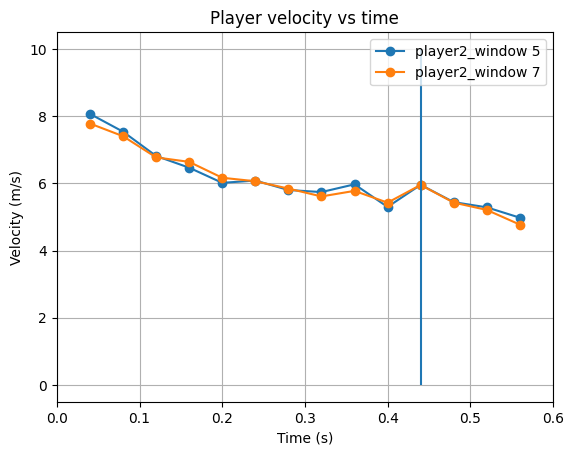

In [17]:
method = "pelvis"

# Player 1
fig, ax = plt.subplots()
for window in [5, 7]:
    with open(dir_case + "/player1-" + method +"_tracking" + ".json") as f:
        pos_array_player1 = json.load(f)
        f.close()
    #print(len(pos_array_player1))
    time_array, velocity_2D, average_v = velocity(pos_array_player1, dst_pts, nrOfframes, sequencelength,window, 3, 'velocity_player1', True, True)
    plot_velocity(velocity_2D, time_array, sequencelength, 'player1_window'+str(window))
plt.vlines(impact_frame/fps, 0, 10)
ax.grid()
save_plot = dir_case + '/velocity_player1_pelvis-low_window.png'
plt.savefig(save_plot)
plt.show()

# Player 2
fig, ax = plt.subplots()
for window in [5, 7]:
    with open(dir_case + "/player2-" + method +"_tracking" + ".json") as f:
        pos_array_player2 = json.load(f)
        f.close()
    time_array, velocity_2D, average_v = velocity(pos_array_player2, dst_pts, nrOfframes, sequencelength,window, 3, 'velocity_player2', True, True)
    plot_velocity(velocity_2D, time_array, sequencelength, 'player2_window '+str(window))
plt.vlines(impact_frame/fps, 0, 10)
ax.grid()
save_plot = dir_case + '/velocity_player2_pelvis-low_window.png'
plt.savefig(save_plot)
plt.show()